# PART 2
This part includes 7 problems that sums up to 60 points. This part aims to help you deepen your knowledge related to audio , which includes audio IO, quantization, sampling and short-time analysis. 60 points totally in this part.

# Audio IO

First, you need to import the necessary libraries

In [1]:
# Load required libraries
import librosa  # for some audio processing
import librosa.display
import IPython.display as ipd  # for playing audios
import matplotlib.pyplot as plt  # matplot lib is the premiere plotting lib for Python: https://matplotlib.org/
import numpy as np  # numpy is the premiere signal handling library for Python: http://www.numpy.org/
import scipy as sp  # for signal processing
from scipy import signal
import random
from utils import *
import struct

### **Problem 1** (10 points): Reading Wave file
You should write a function to load and read important fields from a Wave file. Note that you are not allowed to use any existing functions from librosa and similar libraries. Instead, you need to read file in binary and parse the audio header to get such information. Please refer to http://soundfile.sapp.org/doc/WaveFormat/ for more information about Wave format.

In [2]:
audio_path = "data/music.wav"
# audio_path = "data/HumanVoice-Hello_16bit_44.1kHz_mono.wav"

## Important Note: the above audio file contains a LIST chunk after the fmt subchunk,
## which is different from described in http://soundfile.sapp.org/doc/WaveFormat/,
## You should skip the LIST chunk to reach the data chunk


def read_wavefile(audio_path):
    """Read a wavefile and return:

    sample_rate: the sample rate of the wave form
    num_channels: the number of channes (1 for mono, 2 for stereo)
    number_of_samples: the number of audio samples
    quantization: 1 for uniform quantization and 2 for mu-quantization
    data: a numpy array of size [num_channels, number_of_samples]
    duration: the length of the audio file in second
    """
    ## YOUR CODE HERE
    with open(audio_path, "rb") as f:
        # Read the RIFF header
        riff_header = f.read(4)
        if riff_header != b"RIFF":
            raise ValueError("Not a valid WAV file")

        file_size = struct.unpack("<I", f.read(4))[0]

        wave_id = f.read(4)
        if wave_id != b"WAVE":
            raise ValueError("Not a valid WAV file")

        fmt_header = f.read(4)
        if fmt_header != b"fmt ":
            raise ValueError("fmt subchunk not found")

        fmt_chunk_size = struct.unpack("<I", f.read(4))[0]

        audio_format = struct.unpack("<H", f.read(2))[0]
        quantization = 1 if audio_format == 1 else 2

        num_channels = struct.unpack("<H", f.read(2))[0]

        sample_rate = struct.unpack("<I", f.read(4))[0]

        byte_rate = struct.unpack("<I", f.read(4))[0]
        block_align = struct.unpack("<H", f.read(2))[0]

        bits_per_sample = struct.unpack("<H", f.read(2))[0]

        # Skip any extra bytes in the fmt chunk
        if fmt_chunk_size > 16:
            f.read(fmt_chunk_size - 16)

        # Skip the LIST chunk if present
        while True:
            chunk_header = f.read(4)
            if chunk_header == b"LIST":
                list_chunk_size = struct.unpack("<I", f.read(4))[0]
                f.read(list_chunk_size)
            else:
                f.seek(-4, 1)
                break

        data_header = f.read(4)
        if data_header != b"data":
            raise ValueError("data subchunk not found")

        data_chunk_size = struct.unpack("<I", f.read(4))[0]

        data = np.frombuffer(f.read(data_chunk_size), dtype=np.int16)

        # Reshape the data to [num_channels, number_of_samples]
        number_of_samples = data_chunk_size // (num_channels * (bits_per_sample // 8))
        data = data.reshape((num_channels, number_of_samples))

        duration = number_of_samples / sample_rate

        # Normalize data with int16
        data = data / (2**15)

    return sample_rate, num_channels, number_of_samples, quantization, data, duration


sr, n_channels, n_samples, quantization, data, duration = read_wavefile(audio_path)
print("sample_rate:", sr)
print("num_channels:", n_channels)
print("number_of_samples:", n_samples)
print("quantization:(PCM)", quantization)
print("data:", data)
print("duration:", duration)

# Verify that your answer is correct by loading the file using librosa library

sample_rate: 48000
num_channels: 2
number_of_samples: 11461248
quantization:(PCM) 1
data: [[0.         0.         0.         ... 0.14367676 0.37319946 0.15893555]
 [0.38858032 0.16348267 0.37658691 ... 0.         0.         0.        ]]
duration: 238.776


## Verification

In [3]:
audio_path = "data/music.wav"
audio_data, sample_rate = librosa.load(audio_path, sr=None, mono=False)
print(sample_rate)
print(audio_data)
print(np.shape(audio_data))

48000
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(2, 11461248)


In [4]:
audio_path = "data/HumanVoice-Hello_16bit_44.1kHz_mono.wav"
audio_data, sample_rate = librosa.load(audio_path, sr=None, mono=False)
print(sample_rate)
print(audio_data)
print(np.shape(audio_data))

44100
[-0.00045776 -0.00045776 -0.00061035 ...  0.00482178  0.00439453
  0.00466919]
(30833,)


# Quantization

Quantization convert values of an audio sequence from continuous, real values to discreate values from a set of `2^quantization_bits`.

Sampling rate: 44100 Hz
Number of channels = 1
Total samples: 30833
16-bit audio ranges from -32768 to 32767
Max value: 24125 Avg value: -3.82


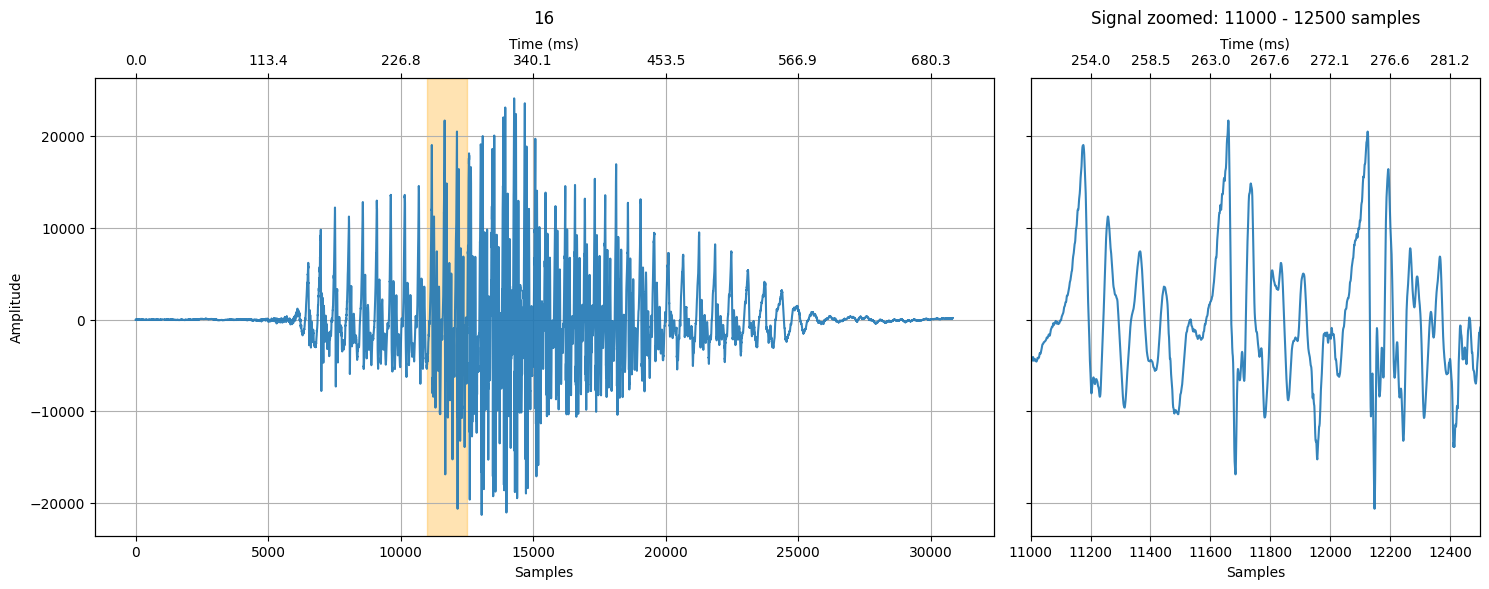

In [5]:
from utils import plot_signal

# Load a sample file with 16 bits quantization
sampling_rate, audio_data_16bit = sp.io.wavfile.read("data/HumanVoice-Hello_16bit_44.1kHz_mono.wav")

print(f"Sampling rate: {sampling_rate} Hz")
print(f"Number of channels = {len(audio_data_16bit.shape)}")
print(f"Total samples: {audio_data_16bit.shape[0]}")


length_in_secs = audio_data_16bit.shape[0] / sampling_rate
quantization_bits = 16
print(
    f"{quantization_bits}-bit audio ranges from -{2**(quantization_bits - 1)} to {2**(quantization_bits - 1) - 1}"
)
print(f"Max value: {np.max(audio_data_16bit)} Avg value: {np.mean(audio_data_16bit):.2f}")

# We'll highlight and zoom in on the orange part of the graph controlled by xlim_zoom
xlim_zoom = (11000, 12500)  # you may want to change this depending on what audio file you have loaded
plot_signal(audio_data_16bit, sampling_rate, quantization_bits, xlim_zoom=xlim_zoom)
ipd.Audio(audio_data_16bit, rate=sampling_rate)

### **Problem 2** (10 points): Experiment with Quantization with different number of bits

Since we do not have the original signal, we pretend that the previously loaded audio is the original one and try to quantize the signal with a changing number of quantization bits. Your task is as follows:

- Experiment with 8-bit, 6-bit, 4-bit, 3-bit and 2-bit quantization. For each quantization level, play the quantized audio data and display the signal as demonstrated with 16-bit quantization above.
- Write a short discussion on the quality of resulting signals with different levels of quantization.
- Implement mu-quantization with 6-bit quantization level. Play the resulting signal and compare the quality with the signal with the same level of bit (6-bit) in uniform quantization.

#### Uniform Quantization 8-bit

8-bit audio ranges from -128 to 127
Max value: 94 Avg value: -0.01


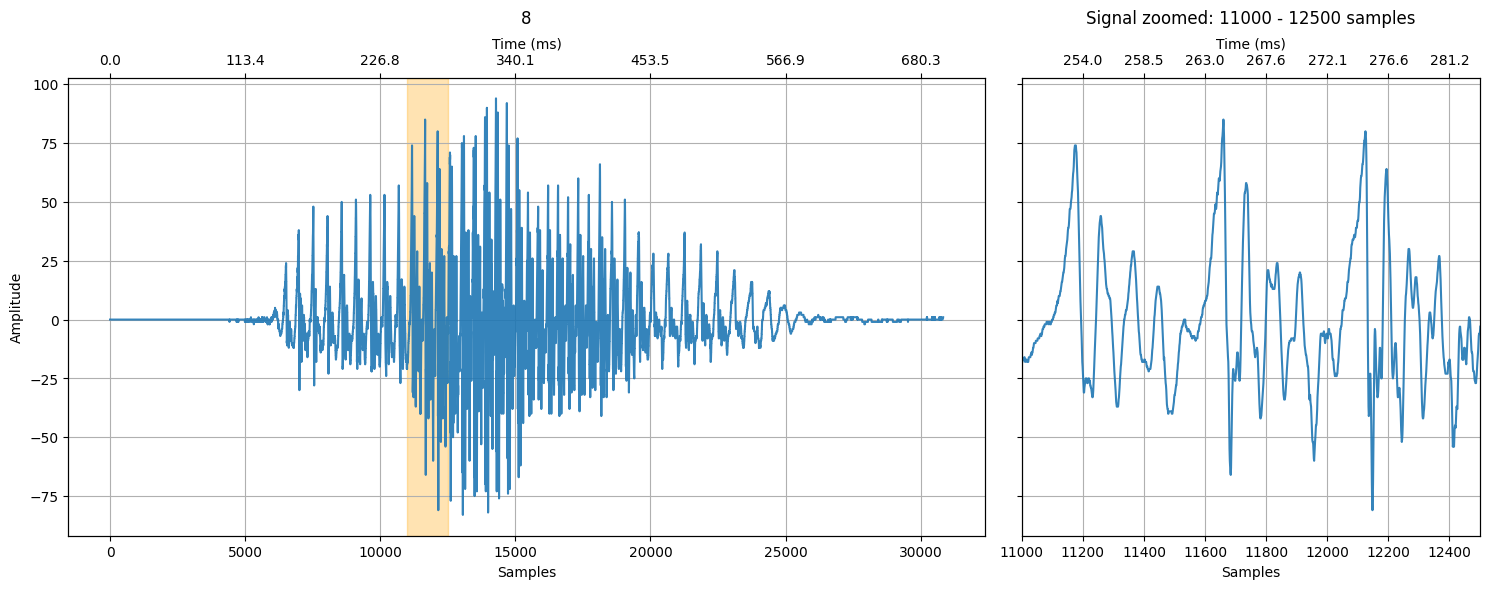

In [6]:
audio_original_data = (audio_data_16bit * 2**16).astype("int64")
# why *(2**16) here?
# or why not /(2**16) for normalization?


def uniform_quantize(audio_original_data, quantization_bits):
    """
    Return the quantized data
    """
    ## YOUR CODE HERE
    # Calculate the quantization step size
    num_levels = 2**quantization_bits
    # max_original = np.max(audio_original_data)
    # min_original = np.min(audio_original_data)
    max_original = 2**31
    min_original = -(2**31)
    step_size = (max_original - min_original) / num_levels

    # Quantize the audio data
    quantized_data = np.floor((audio_original_data - min_original) / step_size + 0.5)
    quantized_data = np.clip(quantized_data, 0, num_levels - 1) - (num_levels // 2)

    # Convert back to the original data type
    quantized_data = quantized_data.astype(audio_original_data.dtype)

    return quantized_data


quantization_bits = 8
audio_data_8bit = uniform_quantize(audio_original_data, quantization_bits)
print(
    f"{quantization_bits}-bit audio ranges from -{2**(quantization_bits - 1)} to {2**(quantization_bits - 1) - 1}"
)
print(f"Max value: {np.max(audio_data_8bit)} Avg value: {np.mean(audio_data_8bit):.2f}")

# We'll highlight and zoom in on the orange part of the graph controlled by xlim_zoom
xlim_zoom = (11000, 12500)  # you may want to change this depending on what audio file you have loaded
plot_signal(audio_data_8bit, sampling_rate, quantization_bits, xlim_zoom=xlim_zoom)
ipd.Audio(audio_data_8bit, rate=sampling_rate)

#### Uniform Quantization 6-bit

Perform the similar procedure as the one with `quantization_bits = 6`

6-bit audio ranges from -32 to 31
Max value: 24 Avg value: 0.00


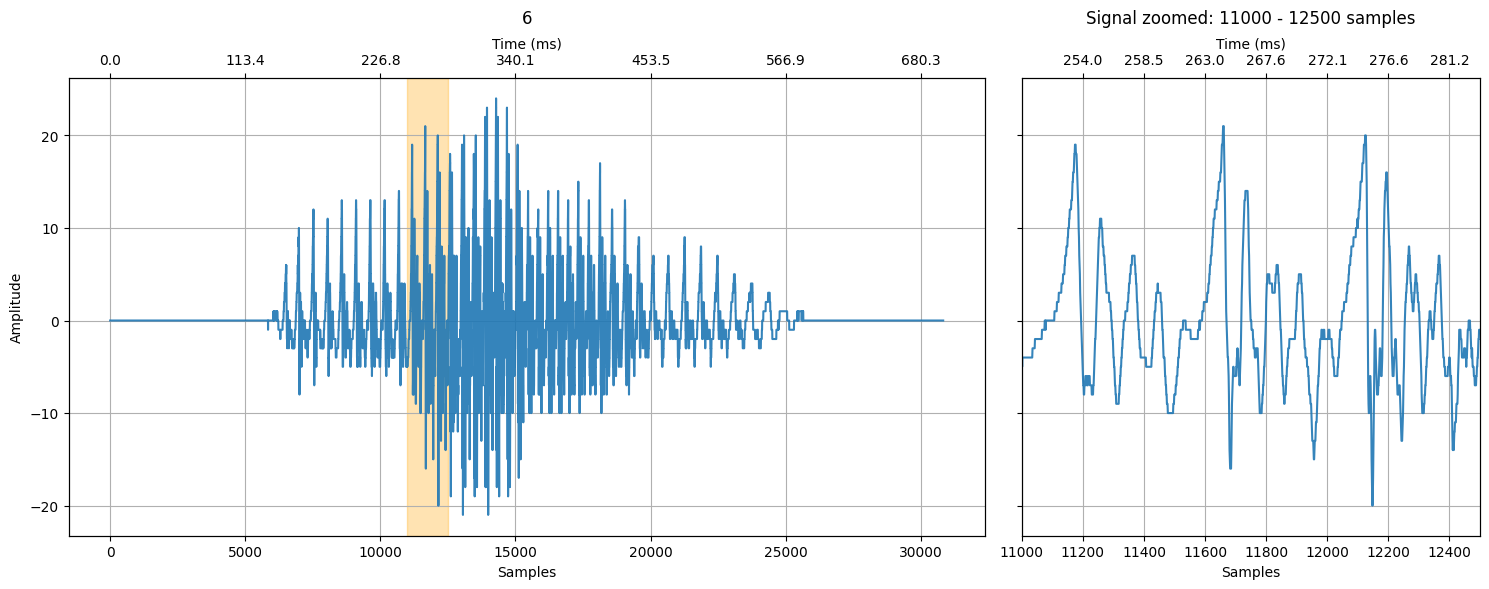

In [7]:
quantization_bits = 6
audio_data_6bit = uniform_quantize(audio_original_data, quantization_bits)
print(
    f"{quantization_bits}-bit audio ranges from -{2**(quantization_bits - 1)} to {2**(quantization_bits - 1) - 1}"
)
print(f"Max value: {np.max(audio_data_6bit)} Avg value: {np.mean(audio_data_6bit):.2f}")

# We'll highlight and zoom in on the orange part of the graph controlled by xlim_zoom
xlim_zoom = (11000, 12500)  # you may want to change this depending on what audio file you have loaded
plot_signal(audio_data_6bit, sampling_rate, quantization_bits, xlim_zoom=xlim_zoom)
ipd.Audio(audio_data_6bit, rate=sampling_rate)

#### Uniform Quantization 4-bit

Perform the similar procedure as above with `quantization_bits = 4`

4-bit audio ranges from -8 to 7
Max value: 6 Avg value: 0.01


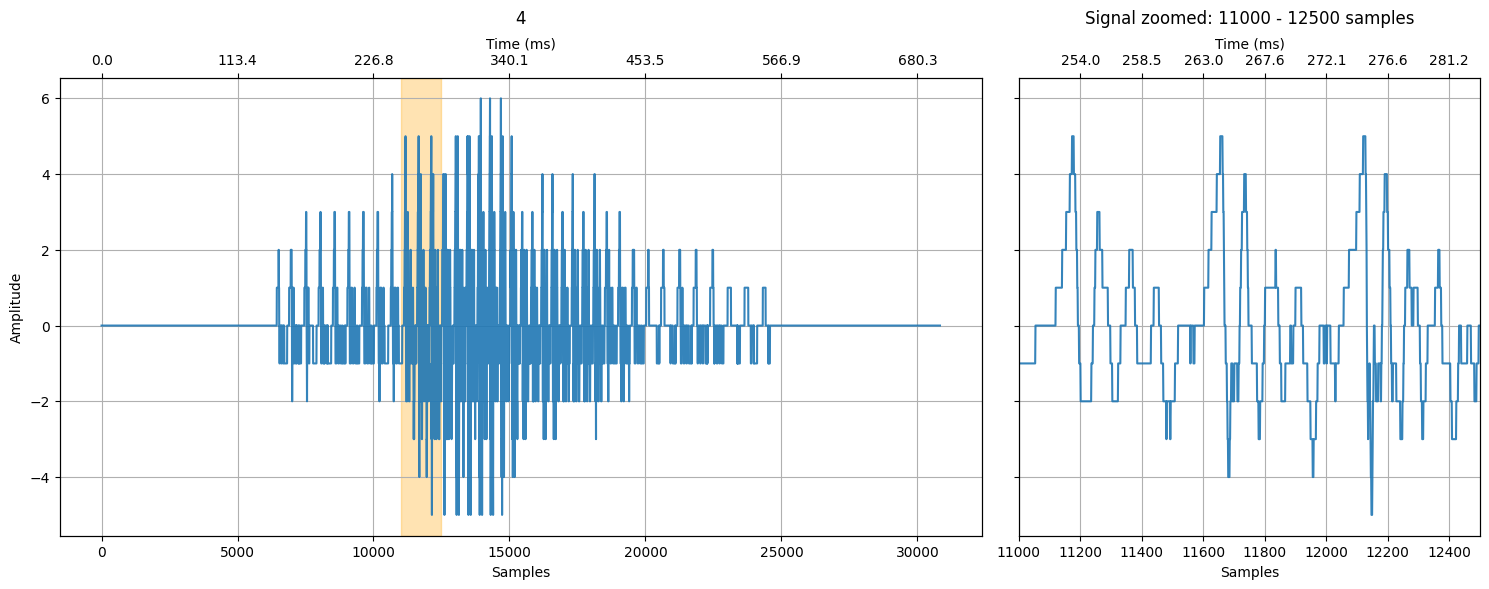

In [8]:
quantization_bits = 4
audio_data_4bit = uniform_quantize(audio_original_data, quantization_bits)
print(
    f"{quantization_bits}-bit audio ranges from -{2**(quantization_bits - 1)} to {2**(quantization_bits - 1) - 1}"
)
print(f"Max value: {np.max(audio_data_4bit)} Avg value: {np.mean(audio_data_4bit):.2f}")

# We'll highlight and zoom in on the orange part of the graph controlled by xlim_zoom
xlim_zoom = (11000, 12500)  # you may want to change this depending on what audio file you have loaded
plot_signal(audio_data_4bit, sampling_rate, quantization_bits, xlim_zoom=xlim_zoom)
ipd.Audio(audio_data_4bit, rate=sampling_rate)

#### Uniform Quantization 3-bit

Perform the similar procedure as above with `quantization_bits = 3`

3-bit audio ranges from -4 to 3
Max value: 3 Avg value: 0.02


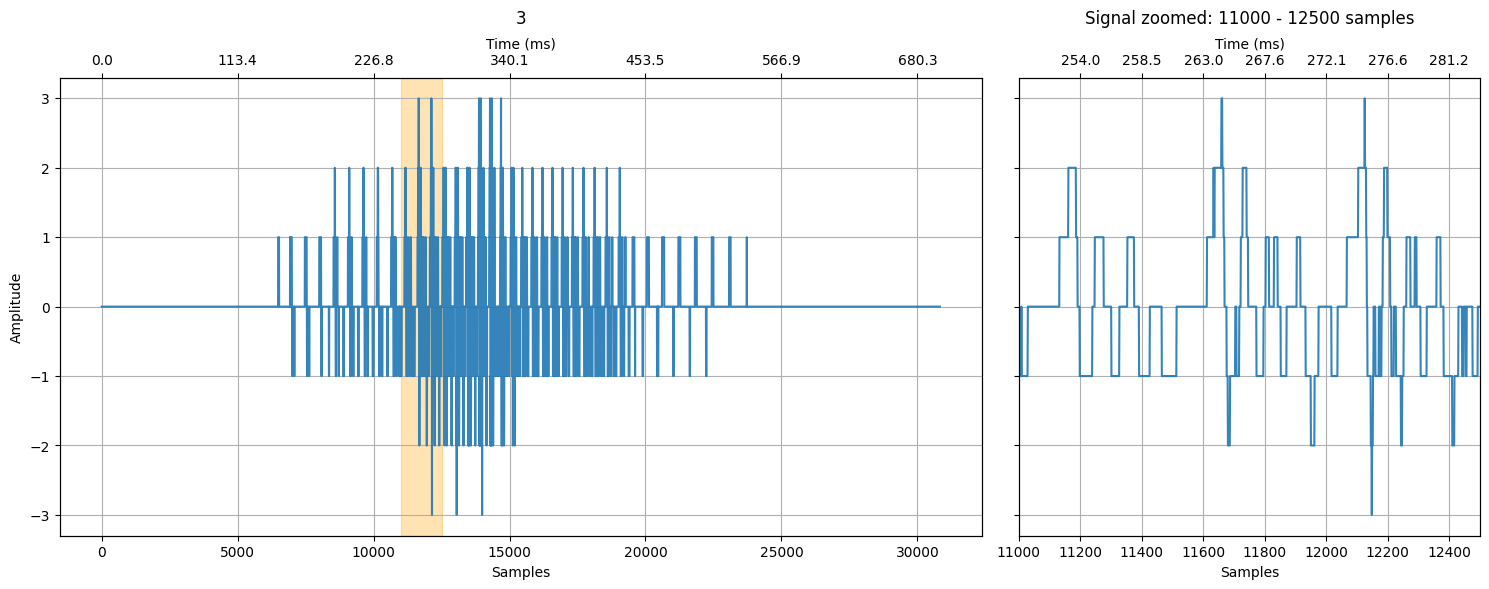

In [9]:
quantization_bits = 3
audio_data_3bit = uniform_quantize(audio_original_data, quantization_bits)
print(
    f"{quantization_bits}-bit audio ranges from -{2**(quantization_bits - 1)} to {2**(quantization_bits - 1) - 1}"
)
print(f"Max value: {np.max(audio_data_3bit)} Avg value: {np.mean(audio_data_3bit):.2f}")

# We'll highlight and zoom in on the orange part of the graph controlled by xlim_zoom
xlim_zoom = (11000, 12500)  # you may want to change this depending on what audio file you have loaded
plot_signal(audio_data_3bit, sampling_rate, quantization_bits, xlim_zoom=xlim_zoom)
ipd.Audio(audio_data_3bit, rate=sampling_rate)

#### Uniform Quantization 2-bit

Perform the similar procedure as above with `quantization_bits = 2`

2-bit audio ranges from -2 to 1
Max value: 1 Avg value: 0.02


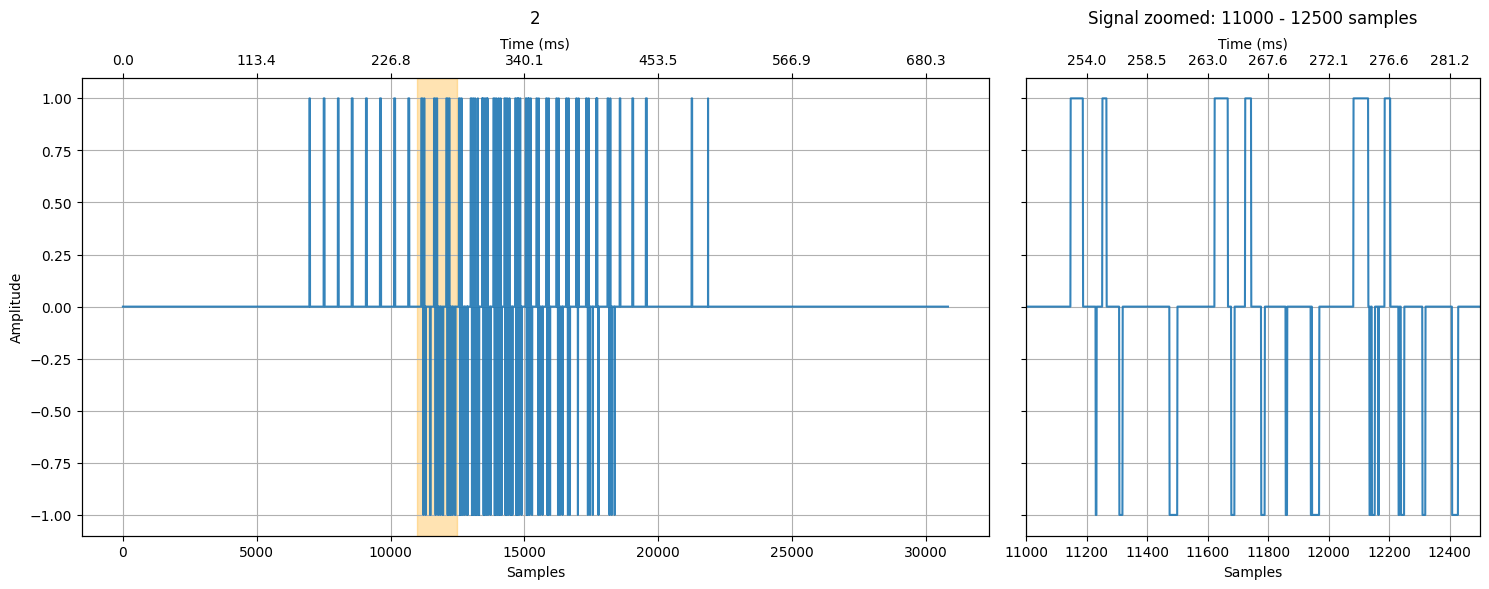

In [10]:
quantization_bits = 2
audio_data_2bit = uniform_quantize(audio_original_data, quantization_bits)
print(
    f"{quantization_bits}-bit audio ranges from -{2**(quantization_bits - 1)} to {2**(quantization_bits - 1) - 1}"
)
print(f"Max value: {np.max(audio_data_2bit)} Avg value: {np.mean(audio_data_2bit):.2f}")

# We'll highlight and zoom in on the orange part of the graph controlled by xlim_zoom
xlim_zoom = (11000, 12500)  # you may want to change this depending on what audio file you have loaded
plot_signal(audio_data_2bit, sampling_rate, quantization_bits, xlim_zoom=xlim_zoom)
ipd.Audio(audio_data_2bit, rate=sampling_rate)

#### **Discussion**

The quality of the resulting signals decreases as the levels of quantization decrease, especially when the number of bits is less than 6.

### **Problem 3** (10 points): Mu-Quantization

Implement mu-quantization with 6-bit quantization level. Play the resulting signal and compare the quality with the signal with the same level of bit (6-bit) in uniform quantization.

In [11]:
def normalize(x):
    """
    Convert a signal from range [min, max] to [-1,1]
    """
    max_x = np.max(x)
    min_x = np.min(x)
    normalized_x = 2 * (x - min_x) / (max_x - min_x) - 1
    return normalized_x


def mu_compress(x, mu=255):
    ### YOUR CODE FOR MU-compression
    x_comp = np.sign(x) * np.log(1 + mu * np.abs(x)) / np.log(1 + mu)
    return x_comp


def mu_expand(x_comp, mu=255):
    """
    Convert the compressed signal to the original signal
    """
    ### YOUR CODE FOR MU-expansion
    x = np.sign(x_comp) * ((1 + mu) ** np.abs(x_comp) - 1) / mu
    return x


normalized_audio_data = normalize(audio_original_data)
compressed_audio_data = mu_compress(normalized_audio_data)
quantization_bits = 6

max_x = np.max(compressed_audio_data)
min_x = np.min(compressed_audio_data)
step_size = (max_x - min_x) / np.power(2, quantization_bits)


### YOUR CODE HERE

# perform uniform quantization
quantized_data = np.floor((compressed_audio_data - min_x) / step_size + 0.5) * step_size + min_x
# restore the ``unquantized signal'' (you may need to keep the min, max of the signal before uniform quantization)
unquantized_signal = ((quantized_data - min_x) / step_size - 0.5) * step_size + min_x + 0.0625
# use mu_expand to restore the signal before compression
restored_signal = mu_expand(unquantized_signal)
# play the audio
ipd.Audio(restored_signal, rate=sampling_rate)

#### **Discussion**
The mu-quantized signal has weaker noise / higher SNR compared to the signal with the same level of 6-bits uniform quantization.

# Sampling

### **Problem 4** (5 points): Experiments with Nyquist limit

In this part, you will experiment with Nyquist limit. The requirement for this part is as follows:
- Write code to generate samples of a sweeping signal, which is the signal with frequency changing over time. The frequency range is from 0 - 22,050Hz within 30 seconds, with the sampling rate of 44,100 Hz. Play the audio and notice how you can't hear any sound when the signal is played from a particular timestamp. Explain the phenomenon.
- Write code to change the sampling rate to 11,025 Hz, 882 Hz, play audio and display the corresponding spectrum. Write your discussion on the observations. Note that for the sampling rate of 882Hz, you may want to use Firefox for running your notebooks as Chrome has some issues when playing signals with a low sampling rate.

d:\Repositories\course\SSP2024\ssp2024_HW1\HW1-v3\utils.py:121: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax_xtick_labels_strs)


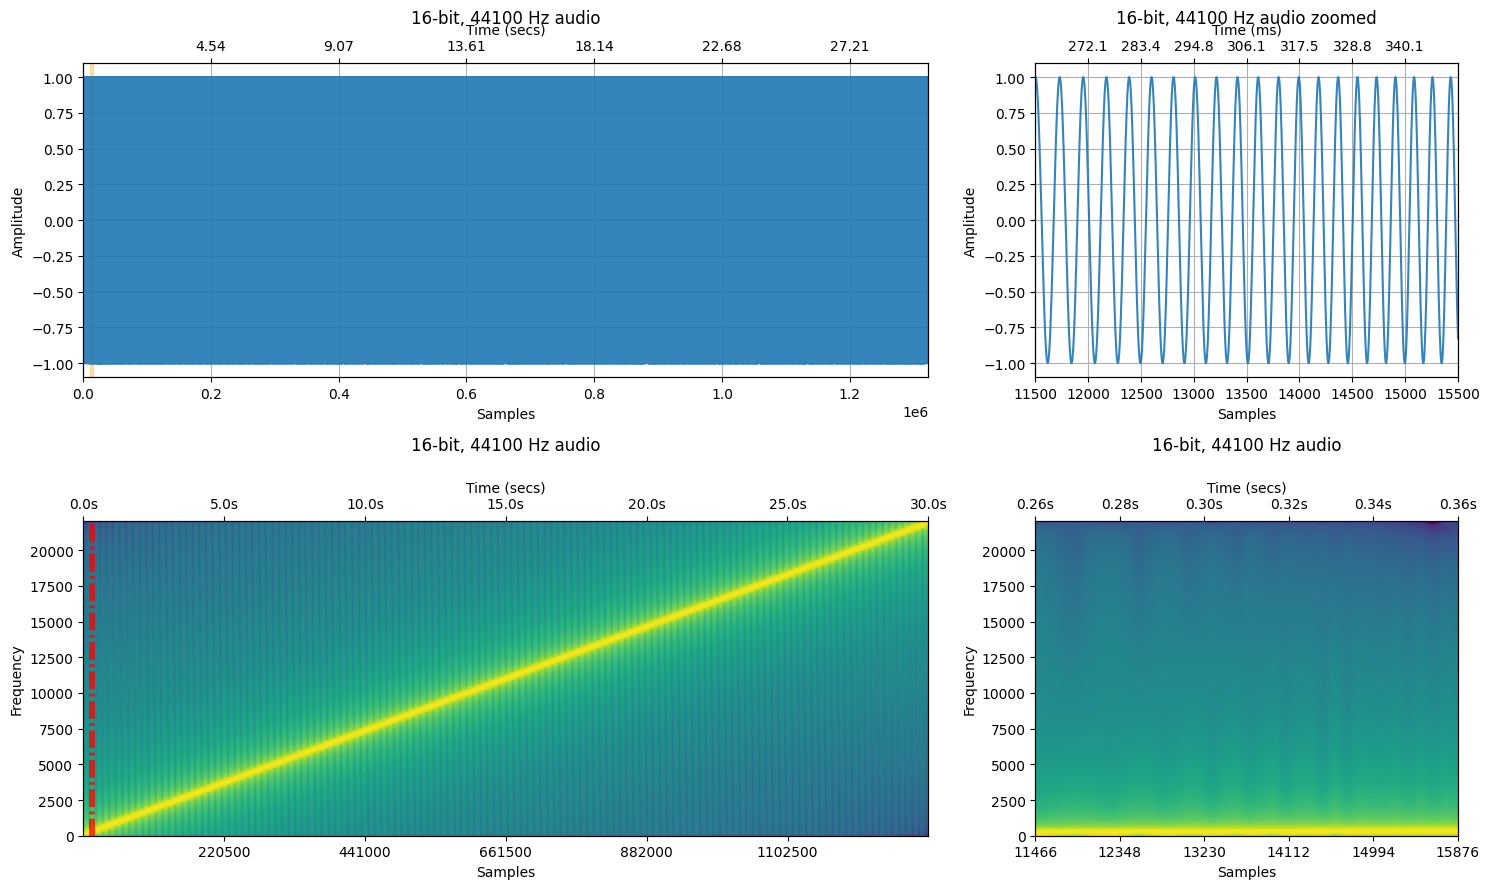

In [12]:
## Generate samples of a sweeping signal with sampling rate 44,100
## Perform uniform quantization with quantization_bits of 16
quantization_bits = 16
sampling_rate = 44100

## TODO: YOUR CODE HERE
duration = 30
start_freq = 0  # Starting frequency in Hz
end_freq = 22050  # Ending frequency in Hz

# get linear_chirp
t = np.linspace(0, duration, duration * sampling_rate)
linear_chirp = signal.chirp(t, start_freq, duration, end_freq, method="linear")

# Set a zoom area (a bit hard to see but highlighted in red in spectrogram)
xlim_zoom = (11500, 15500)
plot_signal_and_spectrogram(linear_chirp, sampling_rate, quantization_bits, xlim_zoom=xlim_zoom)
ipd.Audio(linear_chirp, rate=sampling_rate)

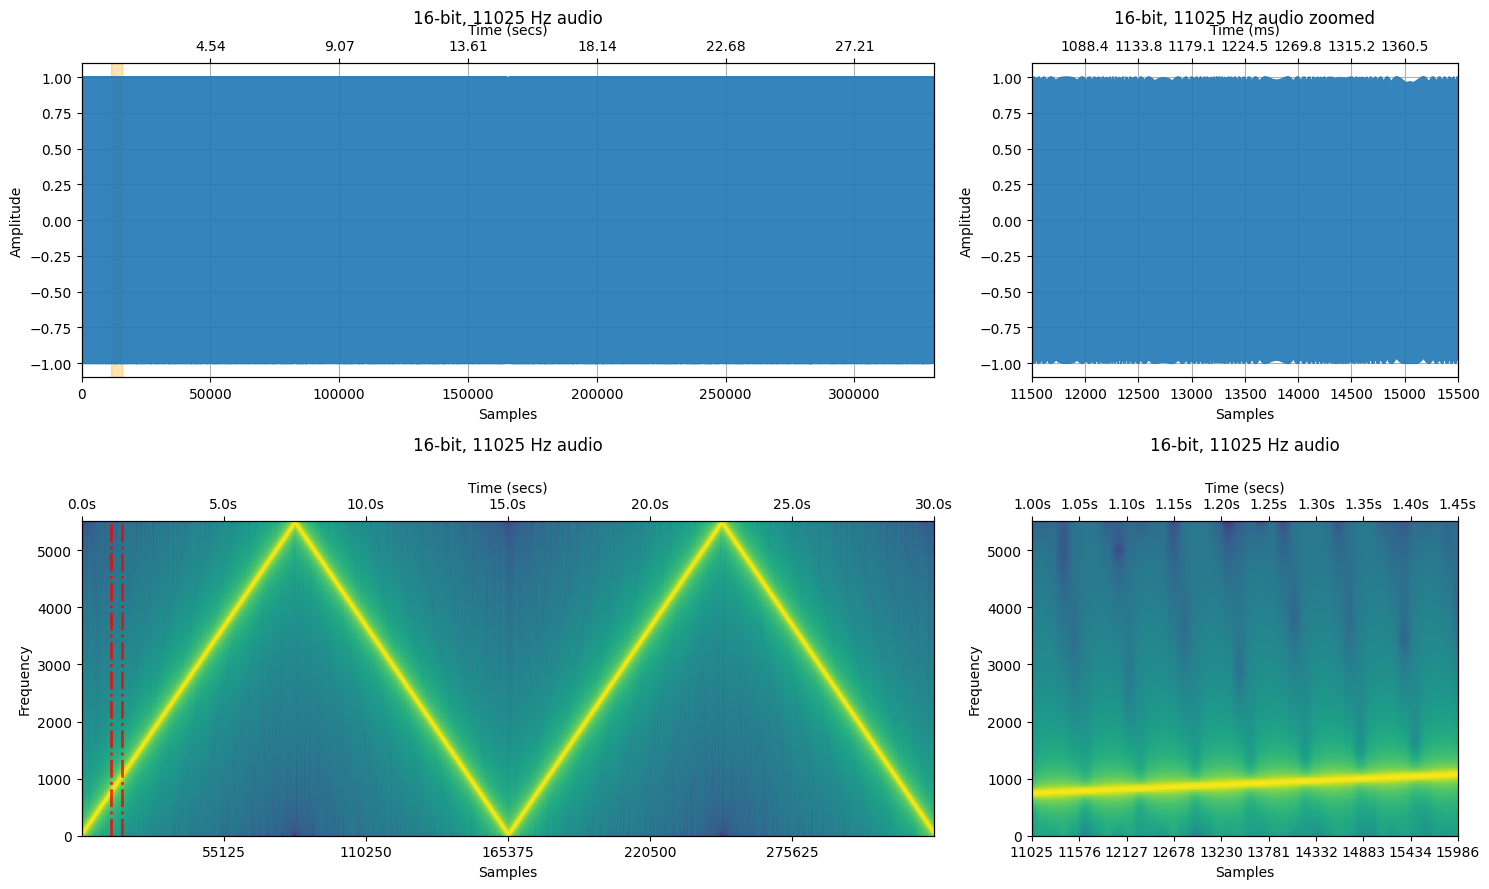

In [13]:
## Generate samples of a sweeping signal with sampling rate 11,025
quantization_bits = 16
sampling_rate = 11025

## TODO: YOUR CODE HERE
duration = 30
start_freq = 0  # Starting frequency in Hz
end_freq = 22025  # Ending frequency in Hz

# get linear_chirp
t = np.linspace(0, duration, duration * sampling_rate)
linear_chirp = signal.chirp(t, start_freq, duration, end_freq, method="linear")

# Set a zoom area (a bit hard to see but highlighted in red in spectrogram)
xlim_zoom = (11500, 15500)
plot_signal_and_spectrogram(linear_chirp, sampling_rate, quantization_bits, xlim_zoom=xlim_zoom)
ipd.Audio(linear_chirp, rate=sampling_rate)

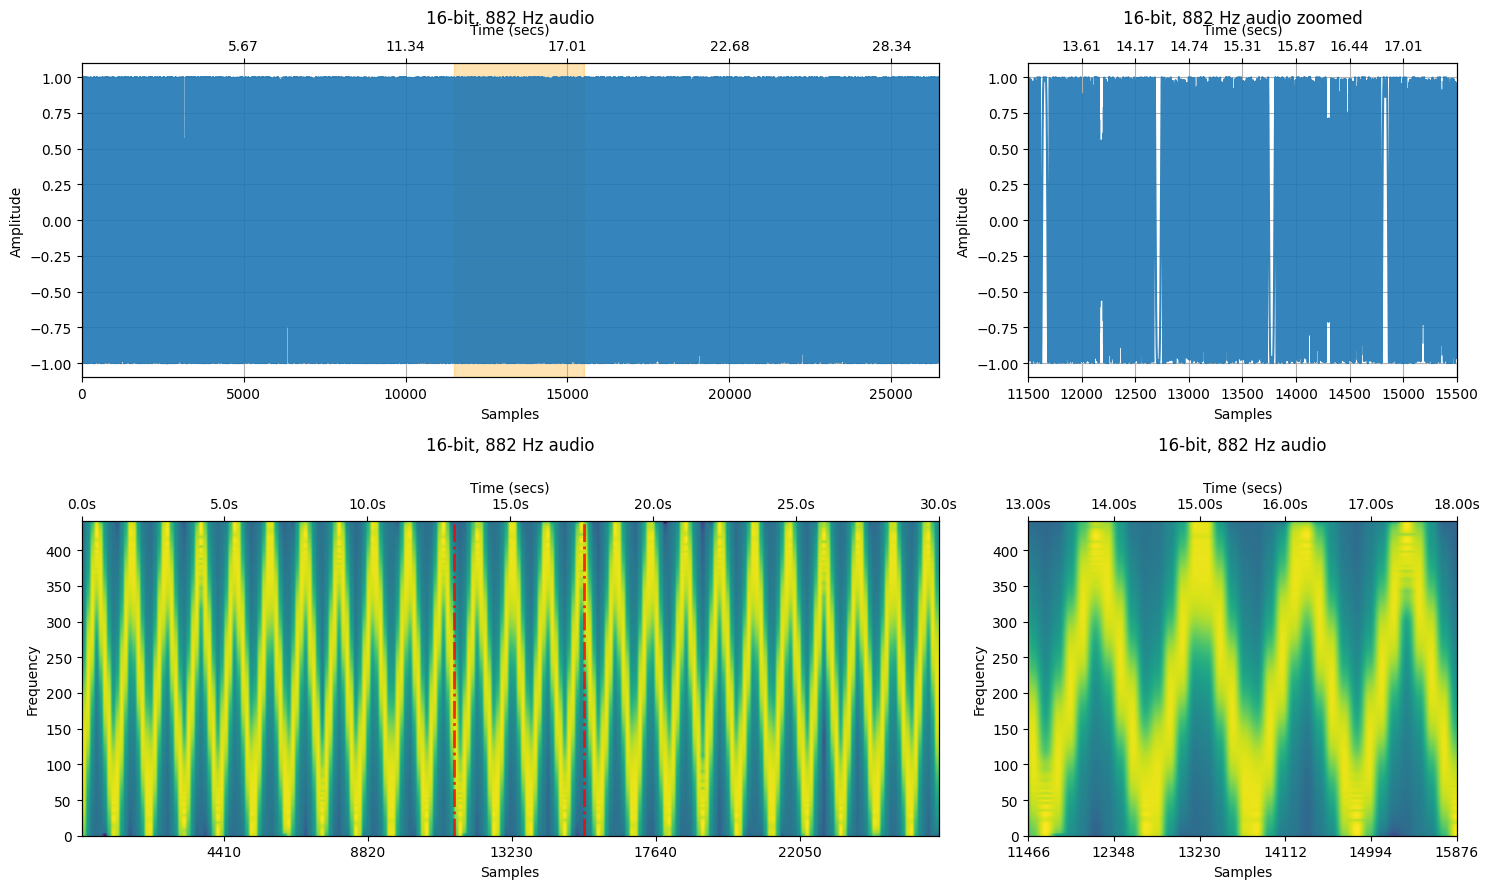

In [14]:
## Generate samples of a sweeping signal with sampling rate 882
quantization_bits = 16
sampling_rate = 882

## TODO: YOUR CODE HERE
duration = 30
start_freq = 0  # Starting frequency in Hz
end_freq = 22025  # Ending frequency in Hz

# get linear_chirp
t = np.linspace(0, duration, duration * sampling_rate)
linear_chirp = signal.chirp(t, start_freq, duration, end_freq, method="linear")

# Set a zoom area (a bit hard to see but highlighted in red in spectrogram)
xlim_zoom = (11500, 15500)
plot_signal_and_spectrogram(linear_chirp, sampling_rate, quantization_bits, xlim_zoom=xlim_zoom)
ipd.Audio(linear_chirp, rate=sampling_rate)

### **Discussion**

- I can't hear any sound when the signal is played for about 20s because human ears can perceive frequencies up to about 20,000 Hz.
- When changing the sampling rate to 11025 Hz or 882 Hz, high-frequency components (with _f_ > 5512.5 Hz or _f_ > 441 Hz) of the original signal is missed due to alias.

# Frequency Analysis

### **Prolem 5** (5 points):  main frequency components
In this problem, you are given the file `samples.txt`, which contain  samples obtained with the sampling rate of 800 (samples/second) from an original signal with unknown frequency. Use the **autocorrelation method** to detect the frequency of the original signal and write down the explaination for your answer.

In [15]:
with open("data/samples.txt", "r") as file:
    samples = [float(line.strip()) for line in file]

### TODO: YOUR CODE HERE

# Calculate the autocorrelation of the samples
autocorr = np.correlate(samples, samples, mode="full")
autocorr = autocorr[len(autocorr) // 2 :]  # Keep only the positive lags

# Find the first peak in the autocorrelation function
first_peak_index = np.argmax(autocorr[1:]) + 1

# Calculate the frequency based on the first peak
sampling_rate = 800
frequency = sampling_rate / first_peak_index

print("Detected Frequency: {:.2f} Hz".format(frequency))

Detected Frequency: 800.00 Hz


**Note**: If there is a significant periodic component in the signal, the autocorrelation calculation will show these periodic features. When the signal repeats within a period, the autocorrelation function will show significant peaks. The spacing of these peak positions can determine the period of the data and thus the main frequency components

### **Problem 6** (10 points): STFT Analysis

Analyze the spectrogram with STFT with different sizes of window length, and observe on the relationship of the window size and the resulting spectrograms.

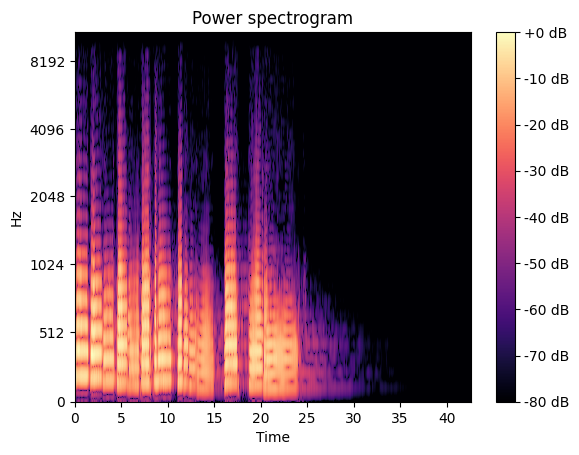

In [16]:
y, sr = librosa.load(librosa.ex("trumpet"))

## TODO:
### 1. Perform STFT analysis with win_length of 125 and hop_length of 64.
### 2. Calculate the power spectrum
### 3. Display the spectrogram
### Note: You can use Librosa for this part

## YOUR CODE HERE
stft_125 = librosa.stft(y, n_fft=2048, hop_length=64, win_length=125)
db_125 = librosa.amplitude_to_db(np.abs(stft_125), ref=np.max)

fig, ax = plt.subplots()
img = librosa.display.specshow(db_125, y_axis="mel", x_axis="time", ax=ax)
ax.set_title("Power spectrogram")
fig.colorbar(img, ax=ax, format="%+2.0f dB")

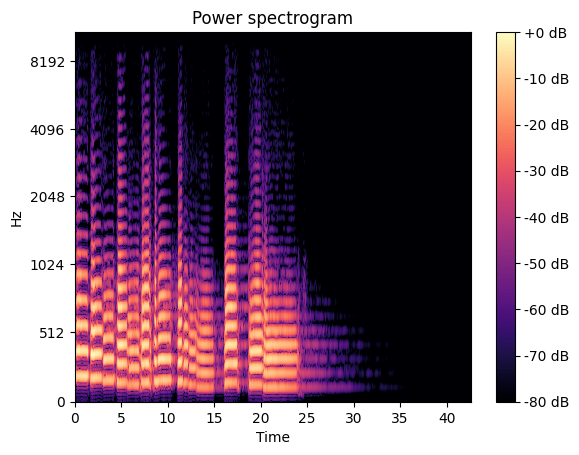

In [17]:
## TODO: Do the same as the above but with the win_length of 256
## YOUR CODE HERE
stft_256 = librosa.stft(y, n_fft=2048, hop_length=64, win_length=256)
db_256 = librosa.amplitude_to_db(np.abs(stft_256), ref=np.max)

fig, ax = plt.subplots()
img = librosa.display.specshow(db_256, y_axis="mel", x_axis="time", ax=ax)
ax.set_title("Power spectrogram")
fig.colorbar(img, ax=ax, format="%+2.0f dB")

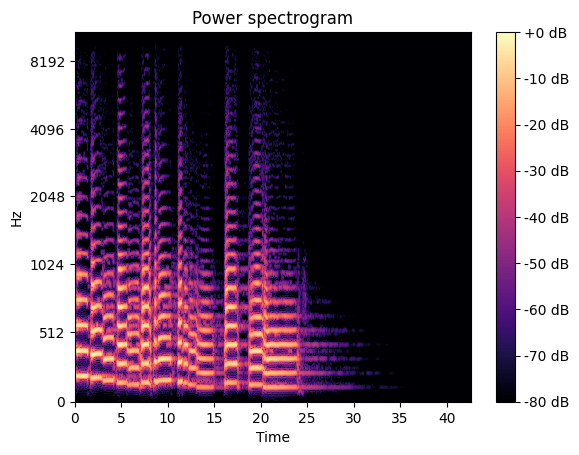

In [18]:
## TODO: Do the same as the above but with the win_length of 512
## YOUR CODE HERE
stft_512 = librosa.stft(y, n_fft=2048, hop_length=64, win_length=512)
db_512 = librosa.amplitude_to_db(np.abs(stft_512), ref=np.max)

fig, ax = plt.subplots()
img = librosa.display.specshow(db_512, y_axis="mel", x_axis="time", ax=ax)
ax.set_title("Power spectrogram")
fig.colorbar(img, ax=ax, format="%+2.0f dB")

#### **Discussion**
On the one hand, as window length of STFT become longer, the frequency resolution becomes higher. We can see different frequency components more clearly with longer window.

On the other hand, longer window brings lower time resolution, leading to smoothed-out transients and a delayed response to changes in the signal

### **Problem 7** (10 points): program our own stft function. 

You cannot use the one in the `librosa` package. To compute fast fourier transforms, use `scipy.fft.fft`.

Concretely, given an audio signal of
```
[ 1 2 3 4 5 6 7 8 9 10 ]
```
a `hop_length` of 2 and a `win_length` of 3 would result in the following windowed segments
```
[ 1 2 3 ] [ 3 4 5 ] [ 5 6 7 ] [ 7 8 9]
```
(here `n_windows = 3`).  
"""why not `n_windows = 4`?"""

Each of these windows would then be put through a fast fourier transform and concatenated along the first dimension.

In [19]:
from scipy.fft import fft


def simple_stft(y, sr, hop_length=512, win_length=2048, n_fft=2048):
    """
    A simple short-time fourier transform.

    Arguments
    ---------
    y: numpy array
       audio signal
    hop_length : integer [default: 512]
                 the number of samples to skip in between windows.
    win_length : integer [default: 2048]
                 the size of a single windowed segment.
    n_fft: integer [default: 2048]
                 number of frequencies for fast fourier transforms.

    Outputs
    -------
    stft_matrix : numpy array
            shape: n_windows x n_fft
            contains amplitudes for the spectrogram.
    """
    # Calculate the number of windows
    n_windows = (len(y) - win_length) // hop_length + 1

    # Initialize the STFT matrix
    stft_matrix = np.zeros((n_windows, n_fft), dtype=np.complex_)

    # Create the Hann window
    window = np.hanning(win_length)

    for i in range(n_windows):
        # Extract the windowed segment
        start = i * hop_length
        end = start + win_length
        segment = y[start:end] * window

        # Compute the FFT and store the result
        stft_matrix[i, :n_fft] = fft(segment, n=n_fft)

    return stft_matrix

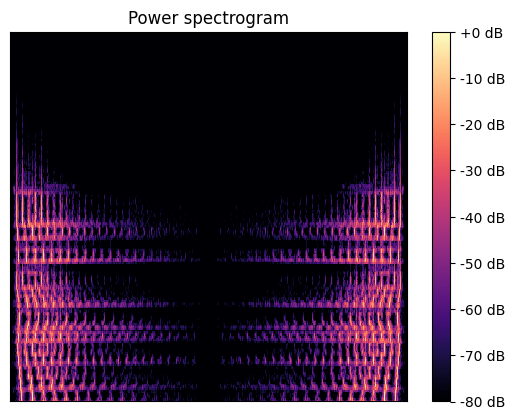

In [20]:
### get the spectrogram
from scipy.fft import rfft, fft

y, sr = librosa.load(librosa.ex("trumpet"))

S = np.abs(simple_stft(y, sr))
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max))
ax.set_title("Power spectrogram")
fig.colorbar(img, ax=ax, format="%+2.0f dB")